In [ ]:
## Set up spark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


In [ ]:
!apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libnvidia-common-460
0 upgraded, 0 newly installed, 1 to remove and 34 not upgraded.
After this operation, 35.8 kB disk space will be freed.
(Reading database ... 161049 files and directories currently installed.)
Removing libnvidia-common-460 (460.73.01-0ubuntu1) ...


In [ ]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
!pip install pyspark_dist_explore

In [ ]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark_dist_explore import hist


from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.sparse.linalg import norm

In [ ]:
## Initialize spark context
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
## get the dataset and unzip, now its in the folder hw2-bundle

!unzip /content/drive/MyDrive/"Colab Notebooks"/CSE547/project/archive.zip -d /content/

textFile = sc.textFile("//",8)

#!unzip hw2-bundle.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/CSE547/project/archive.zip
  inflating: /content/elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: /content/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: /content/elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [ ]:
textFile = sc.textFile("//",8)

In [ ]:
## create dataframes from bitcoin transaction data

# classification of illicit (class 1) versus licit (class 2)
df_class = spark.read.csv('/content/elliptic_bitcoin_dataset/elliptic_txs_classes.csv',header=True)
df_class = df_class.withColumnRenamed("class","cls")
df_class_known = df_class.filter(df_class.cls!='unknown')


# what transactions are connected with an edge
df_edges = spark.read.csv('/content/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv', header=True)

# transaction features
df_features = spark.read.csv('/content/elliptic_bitcoin_dataset/elliptic_txs_features.csv')

df_features = df_features.withColumnRenamed("_c0","txId")
df_features = df_features.withColumnRenamed("_c1","time")

## final dataframe with only labeled transactions, timestamps, and features
df = df_class_known.join(df_features, on=['txId'], how='inner')

In [ ]:
df.show()

+---------+---+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

Text(0.5, 1.0, 'licit versus illicit count')

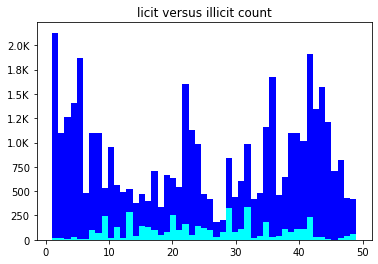

In [ ]:
## Count the number of illicit transactions over time

illicit_count = df.select('time').where(df.cls==1)
illicit_count = illicit_count.withColumn("time", illicit_count["time"].cast(IntegerType()));

## Count the number of licit transactions over time

licit_count = df.select('time').where(df.cls==2)
licit_count = licit_count.withColumn("time", licit_count["time"].cast(IntegerType()));
fig, ax = plt.subplots();
hist(ax, licit_count.select('time'), bins = 49, color=['blue']);
hist(ax, illicit_count.select('time'), bins = 49, color=['cyan']);
ax.set_title('licit versus illicit count')


In [ ]:
### turn strings into double or int  #####

# turn time points to integer
df = df.withColumn("time", df["time"].cast(IntegerType()))

# turn features to double
for j in range(2,167):
  str_name = str('_c')+str(j)
  df = df.withColumn(str_name, df[str_name].cast(DoubleType()))


In [ ]:
###############################################
### create indexers for formatting data  ######
###############################################
# get column feature names
col_features = df.columns
col_features = col_features[3:]

from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = []

label_stringIdx = StringIndexer(inputCol = 'cls', outputCol = 'label')
stages += [label_stringIdx]

numericCols = col_features
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

##############################################
#######    create Pipeline     ###############
##############################################
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

# move labels and features to beginning
selectedCols = ['label', 'features']+cols
df = df.select(selectedCols)
#df.printSchema()

In [ ]:
df.toPandas().head()

,label,features,txId,cls,time,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,...,_c127,_c128,_c129,_c130,_c131,_c132,_c133,_c134,_c135,_c136,_c137,_c138,_c139,_c140,_c141,_c142,_c143,_c144,_c145,_c146,_c147,_c148,_c149,_c150,_c151,_c152,_c153,_c154,_c155,_c156,_c157,_c158,_c159,_c160,_c161,_c162,_c163,_c164,_c165,_c166
0,0.0,"[0.1630541194596208, 1.9637897565339713, -0.64...",232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,0.0,"[-0.005027052534778775, 0.5789407688685692, -0...",232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,...,-0.086194,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,0.0,"[-0.14785245781774153, -0.18466755143291433, -...",232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,...,-0.097719,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,0.0,"[-0.15135672737188927, -0.18466755143291433, -...",27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024669,-0.031272,...,-0.097719,-0.127462,0.003143,0.002426,-0.107516,-0.190820,-0.180486,-0.200607,1.064205,1.063787,-1.373902,-1.348835,-0.282308,-1.400475,-0.975738,-0.975237,-0.168742,-0.454961,-0.420758,-0.436915,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.587217,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,0.0,"[-0.1723057883741684, -0.18466755143291433, -1...",3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,-0.047227,-0.165719,-2.222844,-2.486106,-0.042955,-0.013282,-0.057321,-0.170460,-0.172121,-0.175463,-1.373657,-1.371460,-0.139732,-0.148846,-0.080069,-0.155603,-2.340501,-2.33

In [ ]:
##########################################
### Pick training and test data  #########
##########################################

# take the first time points for training, last time points for testing
df_train = df.filter("time < 35")
df_test = df.filter("time >= 35")

In [ ]:
df_test.toPandas().head()

,label,features,txId,cls,time,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,...,_c127,_c128,_c129,_c130,_c131,_c132,_c133,_c134,_c135,_c136,_c137,_c138,_c139,_c140,_c141,_c142,_c143,_c144,_c145,_c146,_c147,_c148,_c149,_c150,_c151,_c152,_c153,_c154,_c155,_c156,_c157,_c158,_c159,_c160,_c161,_c162,_c163,_c164,_c165,_c166
0,0.0,"[-0.17298232520833517, -0.05524241239876458, -...",54751137,2,35,-0.172982,-0.055242,-1.201369,-0.12197,-0.024025,-0.113002,-0.061584,-0.163642,-0.169456,-0.049707,-0.165945,-0.028741,-0.035391,-0.022711,-0.013282,-0.057401,-0.171150,-0.172908,-0.176264,-0.243300,-0.243452,-0.138604,-0.148192,-0.080147,-0.154706,-0.010763,-0.012107,-0.138625,-0.148200,-0.080147,-0.154722,-0.010669,-0.012005,0.001683,-0.006585,...,-0.097719,-0.127462,0.003143,0.002426,-0.124895,-0.200423,-0.188716,-0.215231,-0.047722,-0.048171,-13.093358,-11.660577,-0.301754,-12.868440,0.183133,0.182748,-0.179070,-0.461363,-0.424672,-0.446237,0.143001,0.142525,-1.511910,-2.466561,-1.059868,-2.286109,0.185597,0.185492,-0.240486,-0.624045,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792
1,0.0,"[-0.1668323335931243, -0.11550793413862606, 1....",67576672,2,35,-0.166832,-0.115508,1.018602,-0.12197,-0.043875,-0.113002,-0.061584,-0.157351,-0.163254,-0.049707,-0.159661,-0.028741,-0.035391,-0.042955,-0.013282,-0.051639,-0.165237,-0.166583,-0.168983,0.887058,0.884557,1.154065,0.676648,-0.080147,0.940627,-0.010763,-0.012107,1.154259,0.676707,-0.080147,0.940745,-0.010669,-0.012005,-0.024657,-0.031262,...,-0.097719,-0.127462,0.003143,0.002426,-0.117845,-0.197705,-0.186872,-0.210651,1.064205,1.063787,0.679463,0.449230,-0.301479,0.604012,-0.975738,-0.975237,-0.140978,-0.385267,-0.346060,-0.360917,-1.015963,-1.016230,1.203124,0.669709,-0.453330,1.053007,-1.116918,-1.116948,-0.216814,-0.581079,-0.532262,-0.575769,-0.979074,-0.978556,0.018279,-0.049041,-0.038193,-0.011377,-1.760926,-1.760984
2,0.0,"[-0.1672332990523817, -0.11508600818537473, 1....",69767012,2,35,-0.167233,-0.115086,1.018602,-0.12197,-0.043875,-0.113002,-0.061584,-0.157761,-0.163658,-0.049707,-0.160071,-0.028741,-0.035391,-0.042955,-0.013282,-0.044754,-0.166139,-0.168182,-0.169458,0.887058,0.884557,1.154065,0.676648,-0.080147,0.940627,-0.010763,-0.012107,1.154259,0.676707,-0.080147,0.940745,-0.010669,-0.012005,-0.024657,-0.031262,...,-0.097719,-0.127462,0.003143,0.002426,-0.112069,0.380488,0.545901,0.455073,-1.159649,-1.160129,0.679493,0.452338,-0.293440,0.605756,-0.975738,-0.975237,-0.141146,1.487199,1.943595,1.456499,-1.015963,-1.016230,1.203124,1.192421,0.153209,1.356563,-1.116918,-1.116948,-0.216814,0.910488,1.283665,0.956938,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
3,1.0,"[-0.17250898736494658, -0.12047268247197605, -...",70384401,1,35,-0.172509,-0.120473,-0.091383,-0.12197,-0.043875,-0.113002,-0.061584,-0.163159,-0.168980,-0.049707,-0.165463,-0.028741,-0.035391,-0.042955,-0.013282,-0.054794,-0.170849,-0.172775,-0.175703,-1.373657,-1.371460,-0.139732,-0.148912,-0.080147,-0.155662,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155662,-0.010669,-0.012005,-0.024669,-0.031272,...,-0.097719,-0.127462,0.003143,0.002426,-0.124427,-0.188840,-0.174117,-0.201822,-1.159649,-1.160129,0.679553,0.451548,-0.295639,0.605346,-0.975738,-0.975237,-0.139862,-0.413346,-0.380817,-0.387835,-1.015963,-1.016230,-0.425896,0.146997,0.759748,-0.161217,1.488113,1.487932,-0.216814,-0.556526,-0.502370,-0.550539,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
4,1.0,"[-0.1728047048085646, -0.1122904251822371, 1.0...",67603017,1,35,-0.172805,-0.112290,1.018602,-0.12197,-0.063725,-0.113002,-0.061584,-0.163461,-0.169278,-0.049707,-0.165765,-0.028741,-0.035391,-0.063200,-0.013282,-0.054829,-0.170967,-0.172908,-0.175843,-0.243300,-0.243452,-0.139732,-0.148912,-0.080147,-0.155662,-0.01

In [ ]:
###########################
#### Model training #######
###########################
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol='label', maxIter=5)
lrModel = lr.fit(df_train)

In [ ]:
###########################
#####   Predictions   #####
###########################
predictions_train = lrModel.transform(df_train)
predictions_train.select('label','rawPrediction','prediction','probability').toPandas().head(5)

predictions = lrModel.transform(df_test)
predictions.select('label','rawPrediction','prediction','probability').toPandas().head(5)



,label,rawPrediction,prediction,probability
0,0.0,"[8.212855161186893, -8.212855161186893]",0.0,"[0.999728928048839, 0.00027107195116105043]"
1,0.0,"[-1.666435550678083, 1.666435550678083]",1.0,"[0.1588999912789705, 0.8411000087210295]"
2,0.0,"[-0.04164595053440001, 0.04164595053440001]",1.0,"[0.4895900168996247, 0.5104099831003752]"
3,1.0,"[-0.04121660086415391, 0.04121660086415391]",1.0,"[0.48969730826742247, 0.5103026917325775]"
4,1.0,"[-1.4838437649639329, 1.4838437649639329]",1.0,"[0.18484754317332888, 0.8151524568266711]"


In [ ]:
######################################
####  Evaluate Classification  #######
######################################
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("AUC = ", evaluator.evaluate(predictions))

accuracy = predictions.filter(predictions.label==predictions.prediction).count()/float(predictions.count())
print("Accuracy : ",accuracy)

AUC =  0.8499173109963722
Accuracy :  0.8089382123575285


In [ ]:
######################################
####  Plot AUC over time  ############
######################################
auc_vec = []
for j in range(35,50):
  condition = "time ="+ str(j)
  pred_tmp = predictions.filter(condition)
  auc_vec.append(evaluator.evaluate(pred_tmp))

Text(0.5, 1.0, 'AUC for test set')

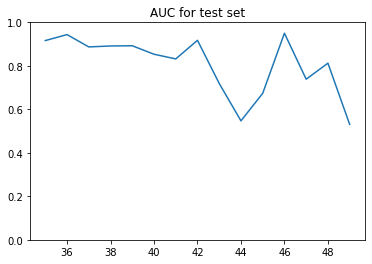

In [ ]:
t_vec = list(range(35,50))
plt.plot(t_vec,auc_vec)
plt.ylim([0, 1])
plt.title('AUC for test set')

In [ ]:
######################################################
######################################################
########                                  ############
########         Active Learning          ############
########                                  ############
######################################################
######################################################
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

#### pick tiny training set
df_train = df.filter("time < 35")
df_test = df.filter("time >= 35")

#### training on whole training set
lr = LogisticRegression(featuresCol = 'features', labelCol='label', maxIter=5)
lrModel = lr.fit(df_train)

#### prediction on whole set
predictions = lrModel.transform(df_test)
auc_whole_set = evaluator.evaluate(predictions)



In [ ]:

################################
###  take subset of data #######
################################
samp_per = 0.001  # take 0.1% of values for training
df_train_small, df_train_extra = df_train.randomSplit([samp_per, 1-samp_per])

####  Model training #####
lrModel = lr.fit(df_train_small)

#####  Predictions  ######
predictions = lrModel.transform(df_test)
auc_initial = evaluator.evaluate(predictions)

###################################
###  add more data round 2  #######
###################################
predictions = lrModel.transform(df_train_extra)

firstelement=udf(lambda v:float(v[0]),FloatType())

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train2 = df_train_small.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train2)
predictions = lrModel.transform(df_test)
auc2 = evaluator.evaluate(predictions)

###################################
###  add more data round 3  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train3 = df_train2.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train3)
predictions = lrModel.transform(df_test)
auc3 = evaluator.evaluate(predictions)

###################################
###  add more data round 4  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train4 = df_train3.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train4)
predictions = lrModel.transform(df_test)
auc4 = evaluator.evaluate(predictions)


###################################
###  add more data round 5  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train5 = df_train4.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train5)
predictions = lrModel.transform(df_test)
auc5 = evaluator.evaluate(predictions)

###################################
###  add more data round 6  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train6 = df_train5.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train6)
predictions = lrModel.transform(df_test)
auc6 = evaluator.evaluate(predictions)

###################################
###  add more data round 7  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train7 = df_train6.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train7)
predictions = lrModel.transform(df_test)
auc7 = evaluator.evaluate(predictions)

###################################
###  add more data round 8  #######
###################################
predictions = lrModel.transform(df_train_extra)

## get candiate data close to 50% threshold
probs = predictions.select('probability').rdd.map(list)
probs = probs.map(lambda x: np.max([x[0][0], x[0][1]]))
probs = probs.collect()
probs.sort()
cutoff = probs[10]
candidates = predictions.select('txId').where((firstelement('probability')<cutoff) & (firstelement('probability')>(1-cutoff)))
candidates = candidates.rdd.map(list)
candidates=candidates.flatMap(lambda x: x)
candidates_txId = candidates.collect()
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(candidates_txId))

## combine new training data with previous data
df_train8 = df_train7.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train8)
predictions = lrModel.transform(df_test)
auc8 = evaluator.evaluate(predictions)


In [ ]:
cutoff

0.5576744133454322

In [ ]:

print('size initial dataset = ',df_train_small.count())
print('size dataset round 2 = ',df_train2.count())
print('size dataset round 3 = ',df_train3.count())
print('size dataset round 4 = ',df_train4.count())
print('size dataset round 5 = ',df_train5.count())
print('size dataset round 6 = ',df_train6.count())
print('size dataset round 7 = ',df_train7.count())
print('size dataset round 8 = ',df_train8.count())
print('auc whole dataset = ',auc_whole_set)
print('auc initial = ',auc_initial)
print('auc round 2 = ',auc2)
print('auc round 3 = ',auc3)
print('auc round 4 = ',auc4)
print('auc round 5 = ',auc5)
print('auc round 6 = ',auc6)
print('auc round 7 = ',auc7)
print('auc round 8 = ',auc8)

size initial dataset =  37
size dataset round 2 =  47
size dataset round 3 =  57
size dataset round 4 =  68
size dataset round 5 =  79
size dataset round 6 =  90
size dataset round 7 =  100
size dataset round 8 =  111
auc whole dataset =  0.8499223759459089
auc initial =  0.8843627887695081
auc round 2 =  0.8852901188284554
auc round 3 =  0.8900992143641259
auc round 4 =  0.8897381515872457
auc round 5 =  0.8860231443905742
auc round 6 =  0.8793260074614111
auc round 7 =  0.8697431525584718
auc round 8 =  0.8722470740438159


In [ ]:
###################################################################################
###################################################################################
########                                                               ############
########      Compare active learning to selecting random points       ############
########                                                               ############
###################################################################################
###################################################################################

####  Model training #####
lrModel = lr.fit(df_train_small)

#####  Predictions  ######
predictions = lrModel.transform(df_test)
auc_initial = evaluator.evaluate(predictions)

#################################################
###  add more data round 2 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train2_rand = df_train_small.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train2_rand)
predictions = lrModel.transform(df_test)
auc2_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 3 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train3_rand = df_train2_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train3_rand)
predictions = lrModel.transform(df_test)
auc3_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 4 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train4_rand = df_train3_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train4_rand)
predictions = lrModel.transform(df_test)
auc4_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 5 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train5_rand = df_train4_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train5_rand)
predictions = lrModel.transform(df_test)
auc5_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 6 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train6_rand = df_train5_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train6_rand)
predictions = lrModel.transform(df_test)
auc6_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 7 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train7_rand = df_train6_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train7_rand)
predictions = lrModel.transform(df_test)
auc7_rand = evaluator.evaluate(predictions)

#################################################
###  add more data round 8 (random data)  #######
#################################################
txIds=df_train_extra.select('txId').rdd.map(list)
txIds = txIds.flatMap(lambda x: x)
txIds = txIds.collect()
txIds_top = txIds[0:10]
candidate_data = df_train_extra.filter(df_train_extra.txId.isin(txIds_top))
df_train_extra = df_train_extra.filter(~df_train_extra.txId.isin(txIds_top))

## combine new training data with previous data
df_train8_rand = df_train7_rand.union(candidate_data)

## train on new dataset
lrModel = lr.fit(df_train8_rand)
predictions = lrModel.transform(df_test)
auc8_rand = evaluator.evaluate(predictions)



In [ ]:


print('size initial dataset = ',df_train_small.count())
print('size dataset round 2 = ',df_train2_rand.count())
print('size dataset round 3 = ',df_train3_rand.count())
print('size dataset round 4 = ',df_train4_rand.count())
print('size dataset round 5 = ',df_train5_rand.count())
print('size dataset round 6 = ',df_train6_rand.count())
print('size dataset round 7 = ',df_train7_rand.count())
print('size dataset round 8 = ',df_train8_rand.count())

print('auc whole dataset = ',auc_whole_set)
print('auc initial = ',auc_initial)
print('auc round 2 rand = ',auc2_rand)
print('auc round 3 rand = ',auc3_rand)
print('auc round 4 rand = ',auc4_rand)
print('auc round 5 rand = ',auc5_rand)
print('auc round 6 rand = ',auc6_rand)
print('auc round 7 rand = ',auc7_rand)
print('auc round 8 rand = ',auc8_rand)


size initial dataset =  37
size dataset round 2 =  47
size dataset round 3 =  57
size dataset round 4 =  67
size dataset round 5 =  77
size dataset round 6 =  87
size dataset round 7 =  97
size dataset round 8 =  107
auc whole dataset =  0.8499223759459089
auc initial =  0.8843620778993977
auc round 2 rand =  0.8705865407052219
auc round 3 rand =  0.8640563101540504
auc round 4 rand =  0.8622117206960528
auc round 5 rand =  0.8686275603986349
auc round 6 rand =  0.8630042816299137
auc round 7 rand =  0.8614474760882546
auc round 8 rand =  0.8555390199269329


In [ ]:
############################################
#####  collect data for plotting   #########
############################################
auc_active_vec = [auc_initial, auc2, auc3, auc4, auc5, auc6, auc7, auc8]
auc_rand_vec = [auc_initial, auc2_rand, auc3_rand, auc4_rand, auc5_rand, auc6_rand, auc7_rand, auc8_rand]

sz_dataset_active = [df_train_small.count(), df_train2.count(), df_train3.count(), df_train4.count(), df_train5.count(), df_train6.count(), df_train7.count(), df_train8.count()]
sz_dataset_rand = [df_train_small.count(), df_train2_rand.count(), df_train3_rand.count(), df_train4_rand.count(), df_train5_rand.count(), df_train6_rand.count(), df_train7_rand.count(), df_train8_rand.count()]

Text(0.5, 1.0, 'AUC using test data')

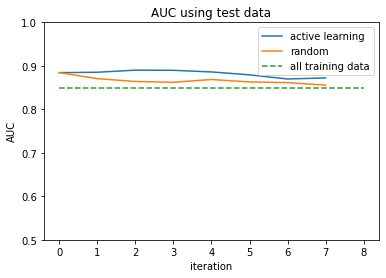

In [ ]:
################################################################
#####  plot active learning versus random data added   #########
################################################################
plt.plot(list(range(0,8)),auc_active_vec)
plt.plot(list(range(0,8)),auc_rand_vec)
plt.plot([0,8], auc_whole_set*np.array([1,1]),linestyle='dashed')
plt.ylim([0.5,1])
plt.legend(['active learning','random','all training data'])
plt.xlabel('iteration')
plt.ylabel('AUC')
plt.title('AUC using test data')

(0.0, 1.0)

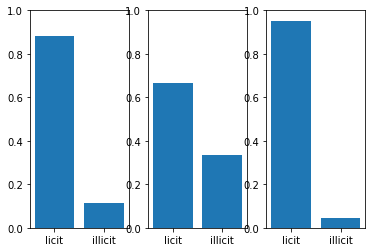

In [ ]:
#####################################################
#### count illicit/licit distribution  ##############
#####################################################

num = df_train.count()

per_licit = (df_train.filter(df_train.label==0).count())/num
per_illicit = (df_train.filter(df_train.label==1).count())/num

num_active = df_train8.count()
per_licit_active = (df_train8.filter(df_train8.label==0).count())/num_active
per_illicit_active = (df_train8.filter(df_train8.label==1).count())/num_active

num_rand = df_train8_rand.count()
per_licit_rand=(df_train8_rand.filter(df_train8_rand.label==0).count())/num_rand
per_illicit_rand=(df_train8_rand.filter(df_train8_rand.label==1).count())/num_rand





Text(0.5, 1.0, 'active learning dataset')

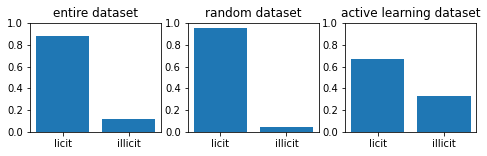

In [ ]:
# using tuple unpacking for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2))
licit_illicit = ['licit','illicit']
ax1.bar(licit_illicit,[per_licit, per_illicit])
ax1.set_ylim([0,1])
ax1.set_title('entire dataset')

ax2.bar(licit_illicit,[per_licit_rand, per_illicit_rand])
ax2.set_ylim([0,1])
ax2.set_title('random dataset')

ax3.bar(licit_illicit,[per_licit_active, per_illicit_active])
ax3.set_ylim([0,1])
ax3.set_title('active learning dataset')

Text(0.5, 1.0, 'training dataset size')

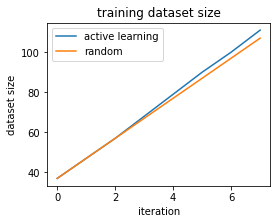

In [ ]:
####################################
#####  plot dataset size   #########
####################################
fig = plt.figure(figsize=(4, 3))
plt.plot(list(range(0,8)),sz_dataset_active)
plt.plot(list(range(0,8)),sz_dataset_rand)
#plt.plot([0,8], num*np.array([1,1]),linestyle='dashed')
plt.xlabel('iteration')
plt.ylabel('dataset size')
plt.legend(['active learning','random'])
plt.title('training dataset size')





[37, 47, 57, 68, 79, 90, 100, 111]